## Importing Libraries !

In [53]:
import time
import datetime
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go

## Reading the dataset

* artists = Contains data of all the artists with their followers, genres, name, popularity

* tracks = Contains data of all the tracks such as release_date, energy, dancebility and more!

* artist_dict = Contains the mapping of the artists to all their songs

In [54]:
artists_df = pd.read_csv('data/artists.csv')
tracks_df = pd.read_csv('data/tracks.csv')
with open('data/dict_artists.json') as json_data:
    data = json.load(json_data)

## Preprocessing

In [55]:
# Dropping genres since high skewness towards null values
artists_df['genres'].value_counts()

artists_df.rename(columns = {'id': 'id_artists','popularity': 'artists_popularity'}, inplace = True)
artists_df.drop(['genres','name'],axis = 1, inplace = True)

# Here we scale the popularity and followers of an artist
# Initialize the Min-Max scaler
minMaxScaler = MinMaxScaler()
standardScaler = StandardScaler()

# Fit and transform the scaler on the training data
artists_df['artists_popularity'] = minMaxScaler.fit_transform(artists_df[['artists_popularity']])
artists_df['followers'] = minMaxScaler.fit_transform(artists_df[['followers']])

artists_df.sort_values(by='followers',ascending=False).head(10)

,id_artists,followers,artists_popularity
144138,6eUKZXaKkcviH0Ku9w2n3V,1.000000,0.92
144485,66CXWjxzNUsdJxJ2JdwvnR,0.776943,0.95
313676,3TVXtAsR1Inumwj472S9r4,0.689691,0.98
144481,1uNFoZAHBGtllmzznpCI3s,0.565359,1.00
144488,7dGJo4pcD2V6oG8kP0tJRR,0.554470,0.94
313508,5pKCCKE2ajJHZ9KAiaK11H,0.535410,0.92
126658,6qqNVTkY8uBg9cP3Jd7DAH,0.529689,0.92
126338,06HL4z0CvFAxyc27GXpf02,0.492637,0.98
126339,53XhwfbYqKCa1cC15pYq2q,0.426688,0.89
144496,1dfeR4HaWDbWqFHLkxsg1d,0.424375,0.89


In [56]:
artists_df.head()

,id_artists,followers,artists_popularity
0,0DheY5irMjBUeLybbCUEZ2,0.000000e+00,0.0
1,0DlhY15l3wsrnlfGio2bjU,6.337117e-08,0.0
2,0DmRESX2JknGPQyO15yxg7,0.000000e+00,0.0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.000000e+00,0.0
4,0Dn11fWM7vHQ3rinvWEl4E,2.534847e-08,0.0


In [57]:
# Extracting artitst id from ['artist_id'] -> string
tracks_df['id_artists'] = [i[2:-2] for i in tracks_df['id_artists']]

# Extracting year from release_date
tracks_df['release_year'] = [int(i.split('-')[0]) for i in tracks_df['release_date']]
# # Removing release date
# tracks_df.drop('release_date', axis=1, inplace=True)

# Fit and transform the scaler on the training data
tracks_df['loudness'] = minMaxScaler.fit_transform(tracks_df[['loudness']])
tracks_df['tempo'] = minMaxScaler.fit_transform(tracks_df[['tempo']])

In [58]:
tracks_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,0.713748,1,0.4510,0.674,0.7440,0.151,0.127,0.425564,3,1922
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,0.579173,1,0.9570,0.797,0.0000,0.148,0.655,0.414029,1,1922
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,0.593796,1,0.0512,0.994,0.0218,0.212,0.457,0.529335,5,1922
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,0.490073,1,0.0504,0.995,0.9180,0.104,0.397,0.689907,3,1922
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0.659263,0,0.0390,0.989,0.1300,0.311,0.196,0.418945,4,1922


### Merge artists into tracks

In [59]:
tracks_exploded = tracks_df.assign(id_artists=tracks_df['id_artists'].str.split(',')).explode('id_artists')

In [60]:
print(len(tracks_df))
print(len(tracks_exploded))

586672
757170


In [61]:
tracks_df_org = tracks_df.merge(artists_df, on = 'id_artists')
print(len(tracks_df_org))

470038


In [62]:
tracks_df_exploded_merge = tracks_exploded.merge(artists_df, on = 'id_artists')
print(len(tracks_df_exploded_merge))

470038


In [63]:
tracks_df = tracks_df.merge(artists_df, on = 'id_artists')
print(len(tracks_df))

470038


In [64]:
tracks_df.drop(['id','id_artists','artists','name'], axis = 1, inplace = True)

In [65]:
tracks_df

,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,followers,artists_popularity
0,6,126903,0,1922-02-22,0.645,0.44500,0,0.713748,1,0.4510,0.674,0.744000,0.1510,0.127,0.425564,3,1922,1.153355e-06,0.04
1,0,157333,0,1922-02-22,0.298,0.46000,1,0.632572,1,0.4530,0.521,0.856000,0.4360,0.402,0.356850,4,1922,1.153355e-06,0.04
2,0,87040,0,1922-02-22,0.634,0.00399,5,0.459297,0,0.0377,0.926,0.919000,0.1050,0.396,0.324274,4,1922,1.153355e-06,0.04
3,0,40000,0,1922-02-22,0.657,0.32500,10,0.698743,0,0.2540,0.199,0.856000,0.0931,0.105,0.332591,5,1922,1.153355e-06,0.04
4,0,104400,0,1922-02-22,0.644,0.68400,7,0.791621,1,0.1990,0.144,0.802000,0.0847,0.138,0.406001,4,1922,1.153355e-06,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470033,50,265846,0,2020-02-25,0.528,0.67300,4,0.862105,1,0.0314,0.143,0.000000,0.0989,0.297,0.527906,4,2020,1.177436e-05,0.36
470034,67,82500,0,2020-10-30,0.609,0.01720,8,0.480712,1,0.1180,0.996,0.973000,0.1080,0.890,0.278508,4,2020,2.915074e-07,0.52
470035,66,185250,0,2020-03-20,0.562,0.03310,1,0.526936,1,0.1030,0.996,0.961000,0.1110,0.386,0.258526,3,2020,1.153355e-06,0.55
470036,50,258267,0,2020-09-26,0.560,0.51800,0,0.803491,0,0.0292,0.785,0.000000,0.0648,0.211,0.535333,4,2020,1.135611e-05,0.38


In [66]:
tracks_df.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,followers,artists_popularity
count,470038.000000,4.700380e+05,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000,470038.000000
mean,28.392524,2.267375e+05,0.034987,0.565913,0.555447,5.223099,0.766583,0.664434,0.100757,0.429147,0.093756,0.213999,0.564334,0.483910,3.879657,1988.854688,0.013498,0.503105
std,17.494863,1.147592e+05,0.183746,0.159077,0.244112,3.520338,0.070648,0.472189,0.178089,0.339304,0.241880,0.185237,0.252629,0.120564,0.456678,21.278759,0.048812,0.196889
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,0.000000
25%,15.000000,1.756470e+05,0.000000,0.460000,0.367000,2.000000,0.726735,0.000000,0.033200,0.088800,0.000000,0.098000,0.361000,0.391106,4.000000,1976.000000,0.000164,0.380000
50%,28.000000,2.147870e+05,0.000000,0.577000,0.560000,5.000000,0.778007,1.000000,0.042800,0.394000,0.000019,0.139000,0.576000,0.479099,4.000000,1992.000000,0.001191,0.520000
75%,41.000000,2.615162e+05,0.000000,0.682000,0.755000,8.000000,0.818787,1.000000,0.071300,0.746000,0.005120,0.278000,0.778000,0.557241,4.000000,2006.000000,0.007545,0.650000
max,99.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,1.000000,1.000000,0.969000,0.996000,1.000000,1.000000,1.000000,1.000000,5.000000,2021.000000,1.000000,1.000000


### Correlation

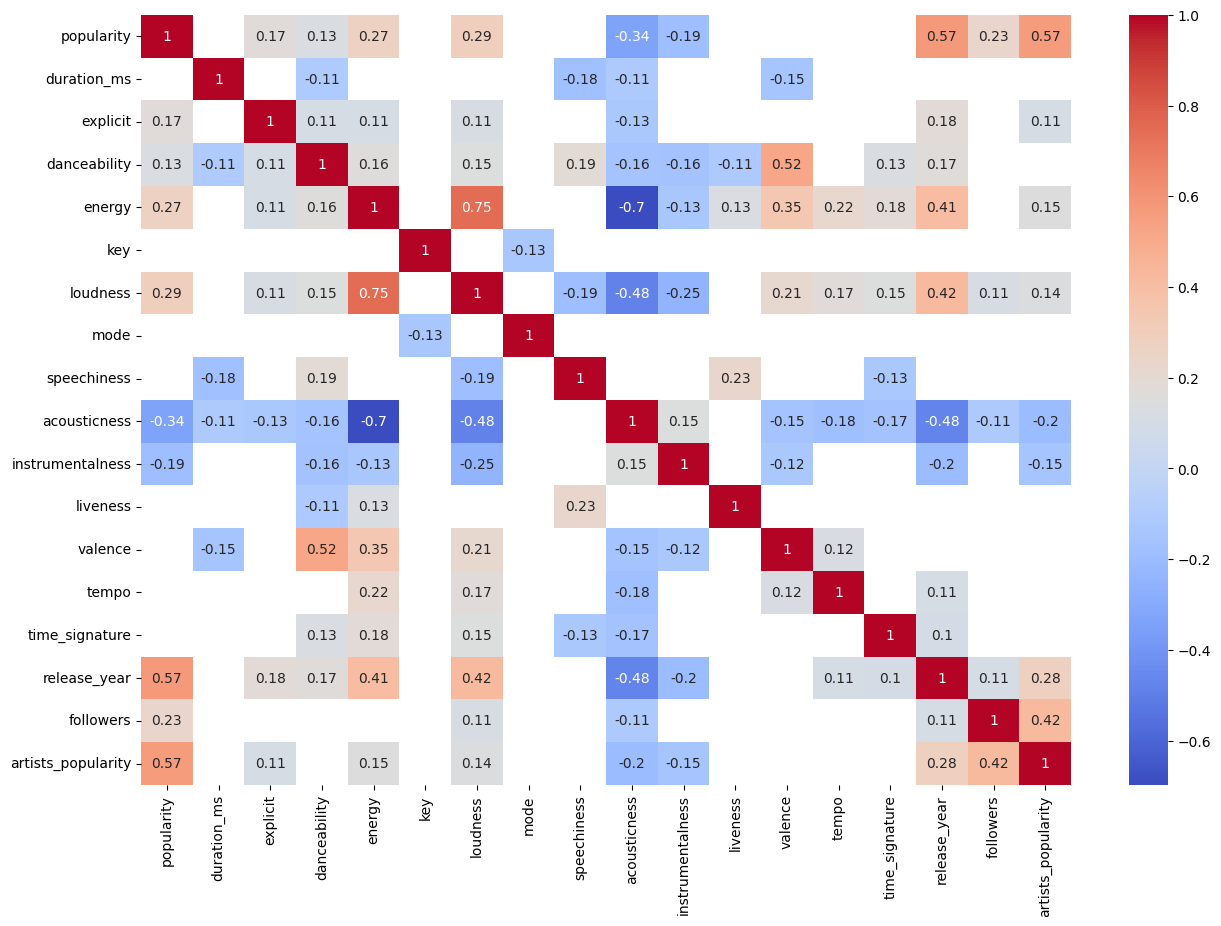

In [67]:
corr_df = tracks_df.drop(['release_date'], axis=1)
corr = corr_df.corr()
fig, ax = plt.subplots(figsize= (15,10))
sns.heatmap(corr[np.absolute(corr)>0.1], annot = True, cmap='coolwarm')
plt.show()

## Feature Selection via Correlation

In [68]:
#tracks_df = tracks_df.query('release_year >= 2008')
#tracks_df = tracks_df.query('popularity!=0')
tracks_df['popularity'] = minMaxScaler.fit_transform(tracks_df[['popularity']])
tracks_df['popularity'].sort_values().value_counts()

features_columns = ["release_date", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness",
            "mode", "speechiness", "tempo", "time_signature", "valence", "popularity"]

tracks_df_processed = tracks_df[features_columns]

In [69]:
data = tracks_df_processed.copy()

In [70]:
tracks_df_processed = data.copy()

## Time-series Analysis

In [71]:
# 'release_date' is in 'YYYY-MM-DD' format
tracks_df_processed['release_date'] = pd.to_datetime(tracks_df_processed['release_date'], format="ISO8601")
tracks_df_processed = tracks_df_processed[tracks_df_processed['release_date'] >= "1920-01-01"]
tracks_df_processed.set_index('release_date', inplace=True)

features = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness",
            "mode", "speechiness", "tempo", "time_signature", "valence"]

# Resampling by month and computing the mean popularity
time_series = tracks_df_processed.resample('6M').mean()

# Split the data by train, test, validation 70%, 15%, 15%
train_size = int(len(time_series) * 0.8)
val_size = int(len(time_series) * 0.19)

train = time_series.iloc[:train_size]
val = time_series.iloc[train_size:train_size+val_size]
# test = time_series.iloc[train_size+val_size:]

In [72]:
# Get parameters
# Fit auto_arima
# auto_model = auto_arima(train['popularity'], exogenous=train[features],
#                         seasonal=False,
#                         start_p=0, start_q=0,
#                         max_p=2, max_q=2, m=2,
#                         start_P=0,
#                         d=1, D=1, trace=True,
#                         error_action='ignore',  
#                         suppress_warnings=True, 
#                         stepwise=False,
#                         max_iter=100)

# Fit ARIMAX model
model = SARIMAX(train['popularity'],  # The target variable
                exog=train[features],  # Exogenous variables
                order=(1,1,2)) # These are ARIMA parameters

# Fit the model
results = model.fit(maxiter=200, method='nm')

# Get preds
val_pred_arimax = results.predict(start=val.index[0], end=val.index[-1], 
                              exog=val[features])

In [73]:
val_pred_arimax

2002-01-31    0.374735
2002-07-31    0.375712
2003-01-31    0.374292
2003-07-31    0.375072
2004-01-31    0.372102
2004-07-31    0.374417
2005-01-31    0.372703
2005-07-31    0.374507
2006-01-31    0.371948
2006-07-31    0.375216
2007-01-31    0.373220
2007-07-31    0.375798
2008-01-31    0.372411
2008-07-31    0.375269
2009-01-31    0.372842
2009-07-31    0.371417
2010-01-31    0.372341
2010-07-31    0.373945
2011-01-31    0.369436
2011-07-31    0.375992
2012-01-31    0.370217
2012-07-31    0.374106
2013-01-31    0.370345
2013-07-31    0.372055
2014-01-31    0.369717
2014-07-31    0.374189
2015-01-31    0.368935
2015-07-31    0.375675
2016-01-31    0.369354
2016-07-31    0.375672
2017-01-31    0.367708
2017-07-31    0.375022
2018-01-31    0.367261
2018-07-31    0.371584
2019-01-31    0.364757
2019-07-31    0.370189
2020-01-31    0.367859
2020-07-31    0.373463
Freq: 6M, Name: predicted_mean, dtype: float64

In [74]:
# Fit Facebook Prophet model
# Preparing the data for Prophet
prophet_df = train.copy()
prophet_df.reset_index(inplace=True) # Release datee becomes index
prophet_df.rename(columns={'release_date': 'ds', 'popularity': 'y'}, inplace=True)

prophet_val = val.copy()
prophet_val.reset_index(inplace=True) # Release datee becomes index
prophet_val.rename(columns={'release_date': 'ds'}, inplace=True)
prophet_val.drop(['popularity'], axis=1, inplace=True)

# Initialize the Prophet model and add regressors
prophet_model = Prophet()

for feature in features:
    prophet_model.add_regressor(feature)

# Fit the model
prophet_model.fit(prophet_df.iloc[:train_size])

# Make future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(prophet_val))
prophet_val.head()

# Predicting
forecast = prophet_model.predict(prophet_val)
forecast

# Extracting predictions for the validation period
val_pred_prophet = forecast['yhat'].values

13:33:16 - cmdstanpy - INFO - Chain [1] start processing
13:33:16 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
print(val_pred_prophet)

[0.32538739 0.32988468 0.32796358 0.33385831 0.33121456 0.33805768
 0.33127134 0.3429483  0.33558532 0.3452069  0.33802084 0.34693389
 0.34336152 0.35182149 0.34127731 0.35151571 0.34391384 0.35385656
 0.34675324 0.35832525 0.34958623 0.36249283 0.34816841 0.35917572
 0.35130393 0.36515839 0.35485995 0.36785937 0.35565167 0.37029294
 0.35240081 0.3692605  0.35467966 0.36686044 0.35372375 0.36760736
 0.36048121 0.37782384]


In [76]:
# Evaluate the two models

# Calculate RMSE for ARIMA
rmse_arima = sqrt(mean_squared_error(val['popularity'], val_pred_arimax))
mae_arima = mean_absolute_error(val['popularity'], val_pred_arimax)
mse_arima = mean_squared_error(val['popularity'], val_pred_arimax)
r2_arima = r2_score(val['popularity'], val_pred_arimax)

# Calculate RMSE, MAE, MSE, and MAPE for Prophet
rmse_prophet = sqrt(mean_squared_error(val['popularity'], val_pred_prophet))
mae_prophet = mean_absolute_error(val['popularity'], val_pred_prophet)
mse_prophet = mean_squared_error(val['popularity'], val_pred_prophet)
r2_prophet = r2_score(val['popularity'], val_pred_prophet)

print(f"Prophet RMSE: {rmse_prophet}")
print(f"Prophet MAE: {mae_prophet}")
print(f"Prophet MSE: {mse_prophet}")
print(f"Prophet r2: {r2_prophet}\n")

print(f"Arima RMSE: {rmse_arima}")
print(f"Arima MAE: {mae_arima}")
print(f"Arima MSE: {mse_arima}")
print(f"Arima r2: {r2_arima}")

Prophet RMSE: 0.05243880604403481
Prophet MAE: 0.04557664506692724
Prophet MSE: 0.0027498283793239015
Prophet r2: -1.3717623296021322

Arima RMSE: 0.04194888508007772
Arima MAE: 0.02741799724916469
Arima MSE: 0.001759708959461567
Arima r2: -0.5177716007645807


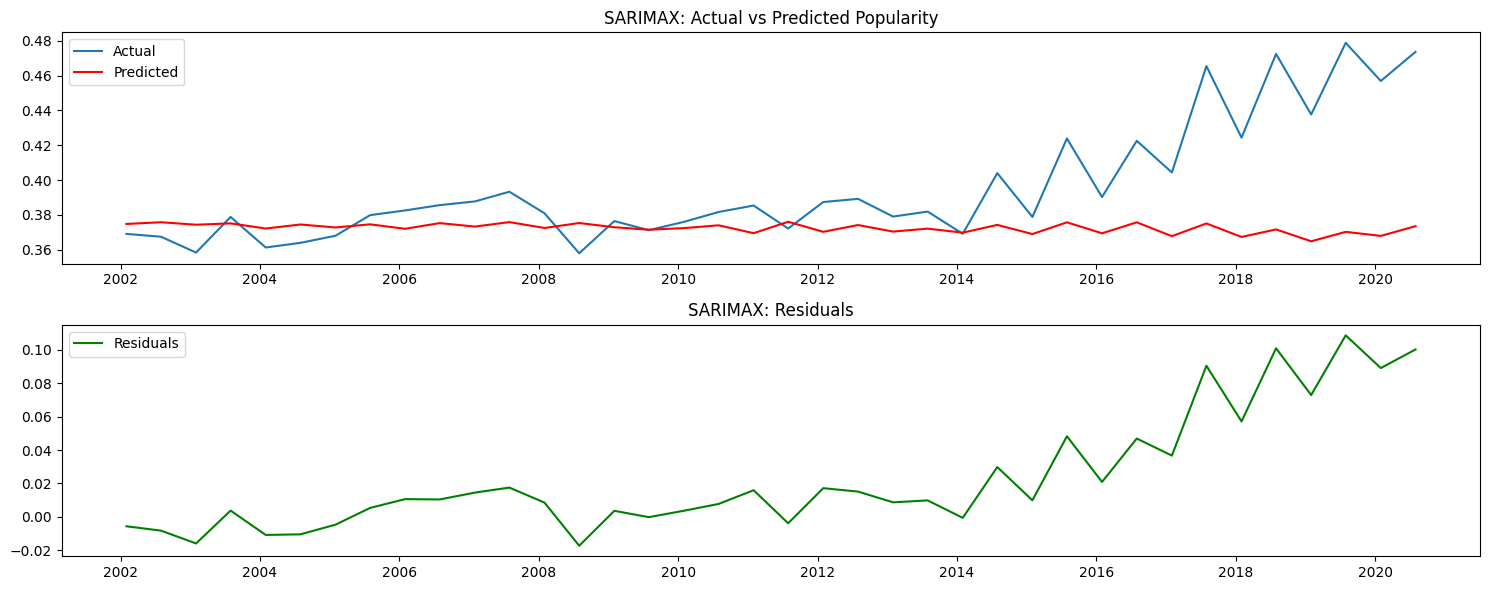

In [77]:
# SARIMAX Visualization
# Assuming 'predictions' is your forecasted values from SARIMAX and 'test' is your test dataset
plt.figure(figsize=(15, 6))

# Actual vs Predicted
plt.subplot(2, 1, 1)
plt.plot(val['popularity'], label='Actual')
plt.plot(val_pred_arimax, label='Predicted', color='red')
plt.title('SARIMAX: Actual vs Predicted Popularity')
plt.legend()

# Residuals
plt.subplot(2, 1, 2)
residuals = val['popularity'] - val_pred_arimax
plt.plot(residuals, label='Residuals', color='green')
plt.title('SARIMAX: Residuals')
plt.legend()

plt.tight_layout()
plt.show()

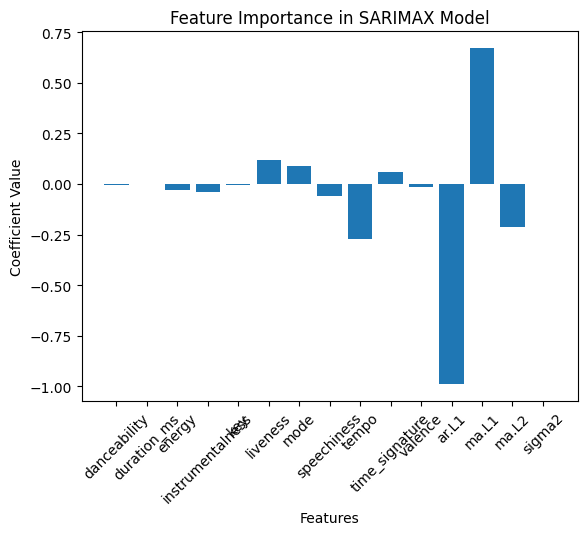

In [79]:
# Assuming 'results' is the fitted SARIMAX model
coefficients = results.params[1:]  # Exclude the intercept

plt.bar(coefficients.index, coefficients.values)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance in SARIMAX Model')
plt.xticks(rotation=45)
plt.show()

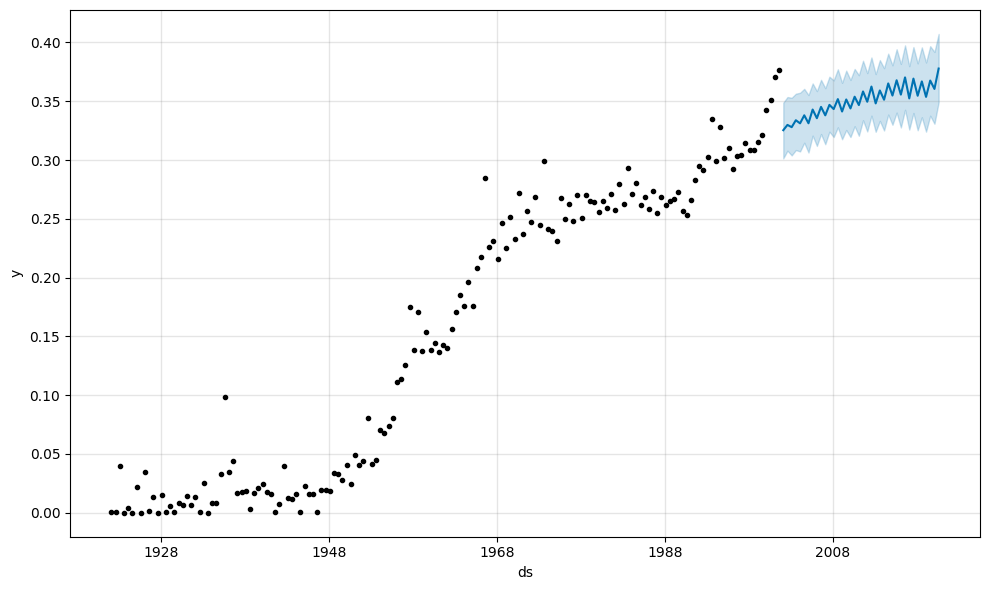

In [84]:
# Prophet visualizations
import plotly.graph_objects as go
# Plot the forecast
fig1 = prophet_model.plot(forecast)

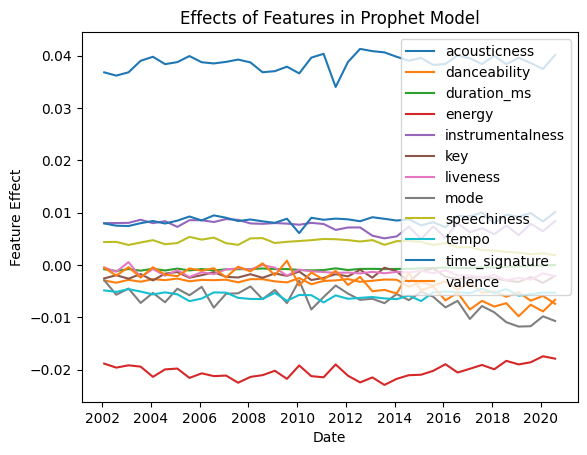

In [80]:
for feature in features:
    plt.plot(forecast['ds'], forecast[feature], label=feature)

plt.xlabel('Date')
plt.ylabel('Feature Effect')
plt.title('Effects of Features in Prophet Model')
plt.legend()
plt.show()

## Regression et al

In [ ]:
!pip install catboost
!pip install lightgbm
!pip install xgboost
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np

# Initialize regression models
models = [
    AdaBoostRegressor(),
    KNeighborsRegressor(),
    MLPRegressor(max_iter=1000),
    XGBRegressor(),
    LGBMRegressor()
]

# Fit each model and evaluate
for model in models:
    model.fit(X_train, y_train)
    model_name = model.__class__.__name__
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)  # Calculating RMSE from MSE
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Metrics for {model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2 score: {r2:.4f}")
    print("-------------------------------")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00
Metrics for AdaBoostRegressor:
MSE: 0.0269
RMSE: 0.1641
MAE: 0.1356
R^2 score: 0.1376
-------------------------------
Metrics for KNeighborsRegressor:
MSE: 0.0342
RMSE: 0.1849
MAE: 0.1494
R^2 score: -0.0952
-------------------------------
Metrics for MLPRegressor:
MSE: 0.1924
RMSE: 0.4386
MAE: 0.3745
R^2 score: -5.1630
-------------------------------
Metrics for XGBRegressor:
MSE: 0.0225
RMSE: 0.1501
MAE: 0.1191
R^2 score: 0.2787
-------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 263221, number of used features: 12
[LightGBM] [Info] Start training from score 0.286445
Metrics for LGBMRegressor:
MSE: 0.0227
RMSE: 0.1505
MAE: 0.1199
R^2 score: 0.2741
-----------------------------

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.datasets import make_regression


# Define models
models = {
    'KNeighbors': KNeighborsRegressor(),
    'MLP': MLPRegressor(max_iter=1000),
    'XGB': XGBRegressor(),
    'LGBM': LGBMRegressor()
}

# Define hyperparameters to search through for each model
param_grid = {
    'KNeighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'alpha': [0.0001, 0.001, 0.01]
    },
    'XGB': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'LGBM': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }
}

# Perform RandomizedSearchCV for each model
best_estimators = {}
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name} using RandomizedSearchCV...")
    random_search = RandomizedSearchCV(model, param_grid[model_name], n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_estimators[model_name] = best_model
    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    print(f"Best score for {model_name}: {random_search.best_score_}")
    print()
    # Now you can use the best model for predictions on new data
    predictions = best_model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)  # Calculating RMSE from MSE
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Metrics for {model}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2 score: {r2:.4f}")
    print(best_model)
    print("-------------------------------")

# Access best estimators
print(best_estimators['KNeighbors'])
print(best_estimators['MLP'])
print(best_estimators['XGB'])
print(best_estimators['LGBM'])

Tuning hyperparameters for KNeighbors using RandomizedSearchCV...
Best parameters for KNeighbors: {'weights': 'uniform', 'n_neighbors': 7}
Best score for KNeighbors: -0.03309746038332164

Metrics for KNeighborsRegressor():
MSE: 0.0329
RMSE: 0.1813
MAE: 0.1470
R^2 score: -0.0534
KNeighborsRegressor(n_neighbors=7)
-------------------------------
Tuning hyperparameters for MLP using RandomizedSearchCV...
Best parameters for MLP: {'hidden_layer_sizes': (50, 50), 'alpha': 0.01}
Best score for MLP: -2.585965742344848

Metrics for MLPRegressor(max_iter=1000):
MSE: 105143.5640
RMSE: 324.2585
MAE: 288.9357
R^2 score: -3368269.0951
MLPRegressor(alpha=0.01, hidden_layer_sizes=(50, 50), max_iter=1000)
-------------------------------
Tuning hyperparameters for XGB using RandomizedSearchCV...
Best parameters for XGB: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}
Best score for XGB: -0.022527210347245183

Metrics for XGBRegressor(base_score=None, booster=None, callbacks=None,
          

# Feature Selection

In [ ]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# # Generate a sample regression dataset
# X, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=42)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a regression model (replace with your specific model)
regression_model = Ridge()

# Create RFECV with a regression model and cross-validation strategy
rfecv = RFECV(estimator=regression_model, step=1, cv=4, scoring='neg_mean_squared_error')

# Fit RFECV to the training data
rfecv = rfecv.fit(X_train, y_train)
print(rfecv.support_)
print(rfecv.ranking_)

# Print the optimal number of features
print("Optimal number of features: {}".format(rfecv.n_features_))

# grid = rfecv.regularization_path_.mean(axis=1)
# # Plot the number of features vs. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross-validation score (negative MSE)")
# plt.plot(range(1, len(grid) + 1), grid)
# plt.show()


[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]
Optimal number of features: 10


In [ ]:
X_train.shape

(800, 10)

In [ ]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate a sample regression dataset
# X, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=42)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a regression model (replace with your specific model)
regression_model = LinearRegression()

# Create SelectKBest with the f_regression scoring function
# 'k' is the number of top features to select
select_k_best = SelectKBest(score_func=f_regression, k=9)

# Fit and transform the training data
X_train_selected = select_k_best.fit_transform(X_train, y_train)

# Transform the testing data
X_test_selected = select_k_best.transform(X_test)

# Fit the model on the selected features
regression_model.fit(X_train_selected, y_train)

# Make predictions on the testing data
y_pred = regression_model.predict(X_test_selected)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)


Mean Squared Error on Test Set: 26.034611545974425


In [ ]:
# 